In [173]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

# Model

In [178]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size) #resize
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB) #RGB로 변환
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [179]:
# 사전학습된 가중치 불러오기
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

# 모델 불러오기
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [180]:
# 사전학습 시킨 PASCAL VOC의 라벨
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

## Person

In [177]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/face.jpeg'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(827, 620, 3)


In [181]:
# 원본 및 resized image의 형태, 라벨의 최댓값(15는 사람을 의미)
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(827, 620, 3) (513, 384, 3) 15


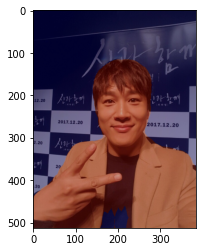

In [155]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출, 나머지는 0으로 출력
img_mask = seg_map * (255/seg_map.max()) # 사람에 해당하는 픽셀만 255
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) #color map 적용(255->128로 바뀐다)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0) #0.6*img_show + 0.35*color_mask + 0.0

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

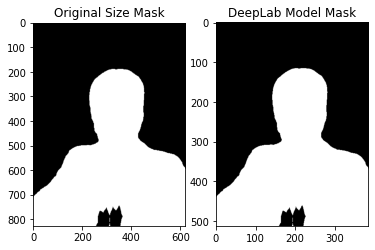

In [156]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) #원본 크기로 복원
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) #임계값(128) 넘으면 255로 만들어준다

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r) #원본 binary로 출력
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r) #DeepLab으로 추출한 mask 
ax.set_title('DeepLab Model Mask')

plt.show()

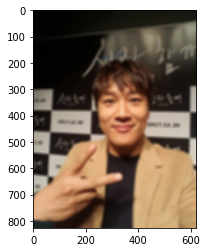

In [157]:
# blur
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

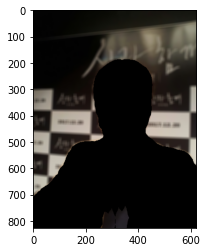

In [158]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR) #BGR 형태로 변환
img_bg_mask = cv2.bitwise_not(img_mask_color) #사람은 0, 배경은 255
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 사람은 0, 배경은 blur
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB)) 
plt.show()

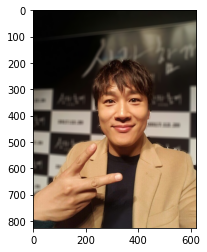

In [159]:
#사람에 해당하는 곳은 img_orig의 픽셀로, 그 외의 영역은 img_bg_blur의 픽셀로 채워준다
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Cat

객체가 여러 개여도 잘 추출하는지 확인하기 위해 고양이는 여러 마리가 있는 사진을 사용해보겠습니다.

In [224]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(449, 598, 3)


In [225]:
# 고양이는 라벨 8에 해당
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(449, 598, 3) (385, 513, 3) 8


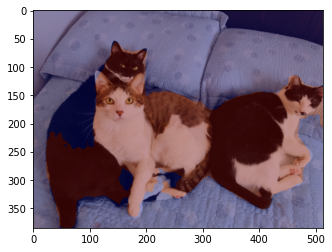

In [226]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출, 나머지는 0으로 출력
img_mask = seg_map * (255/seg_map.max()) # 고양이에 해당하는 픽셀만 255
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) #color map 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0) #0.6*img_show + 0.35*color_mask + 0.0

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

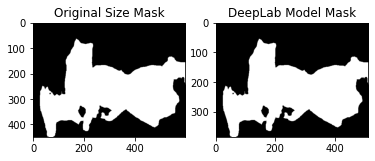

In [216]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) #원본 크기로 복원
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) #임계값(128) 넘으면 255로 만들어준다

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r) 
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r) 
ax.set_title('DeepLab Model Mask')

plt.show()

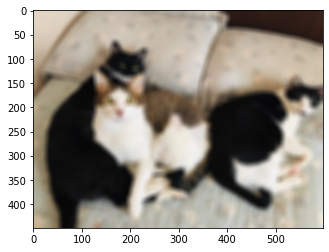

In [217]:
# blur
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

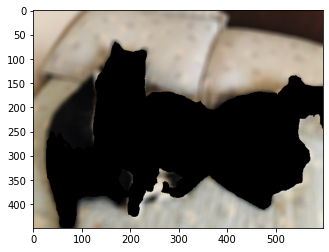

In [231]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR) #BGR 형태로 변환
img_bg_mask = cv2.bitwise_not(img_mask_color) #고양이는 0, 배경은 255
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 고양이는 0, 배경은 blur의 픽셀
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB)) 
plt.show()

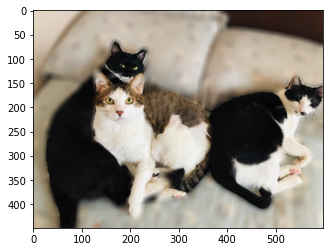

In [219]:
#고양이에 해당하는 곳은 img_orig의 픽셀로, 그 외의 영역은 img_bg_blur의 픽셀로 채워준다
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

왼쪽 고양이가 제대로 인식되지 않으면서 문제가 생기는 것을 확인할 수 있었습니다. 가운데와 오른쪽 고양이가 잘 인식되는 것을 보면 객체가 여러 개인 것 자체는 문제가 없지만 객체가 겹쳐있어 가려지는 경우에는 segmentation을 정확히 하는데 어려움이 있어보입니다.

## Cromakey

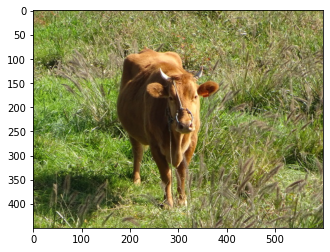

In [269]:
cow_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cow3.jpeg'  
cow_orig = cv2.imread(cow_path) 
plt.imshow(cv2.cvtColor(cow_orig, cv2.COLOR_BGR2RGB))
plt.show()

크로마키에서는 소 사진을 활용해보겠습니다. 날도 더운데 맨날 들판에만 있는 소가 안타깝습니다.

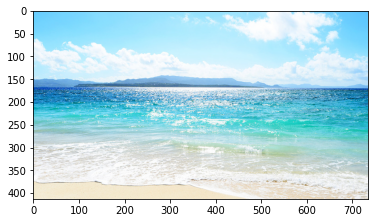

In [270]:
sea_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sea.jpeg'  
sea_orig = cv2.imread(sea_path) 
plt.imshow(cv2.cvtColor(sea_orig, cv2.COLOR_BGR2RGB))
plt.show()

소한테 바다구경 좀 시켜주겠습니다.

In [271]:
# 소는 라벨 10에 해당
cow_resized, seg_map = MODEL.run(cow_orig)
print (cow_orig.shape, cow_resized.shape, seg_map.max())

(450, 600, 3) (384, 513, 3) 10


In [272]:
cow_show = cow_resized.copy()
seg_map = np.where(seg_map == 10, 10, 0) # 예측 중 소만 추출, 나머지는 0으로 출력
cow_mask = seg_map * (255/seg_map.max()) # 소에 해당하는 픽셀만 255
cow_mask = cow_mask.astype(np.uint8)

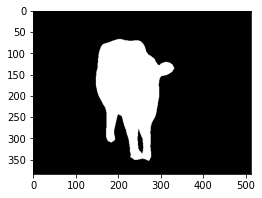

In [278]:
plt.figure(figsize=(5,3))
plt.imshow(cow_mask, cmap=plt.cm.binary_r) 
ax.set_title('DeepLab Model Mask')

plt.show()

In [274]:
print(sea_orig.shape)
print(cow_mask.shape)

(413, 735, 3)
(384, 513)


배경과 객체 이미지의 사이즈가 다르니 cow_mask에 맞춰서 resize를 해주겠습니다.

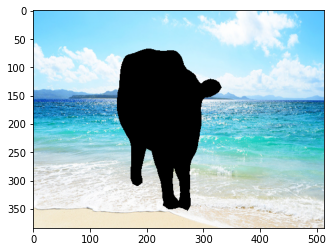

In [275]:
resized_sea = cv2.resize(sea_orig, (513,384)) #resize
cow_mask_color = cv2.cvtColor(cow_mask, cv2.COLOR_GRAY2BGR) #BGR 형태로 변환
cow_bg_mask = cv2.bitwise_not(cow_mask_color) #소는 0, 배경은 255
cow_bg = cv2.bitwise_and(resized_sea, cow_bg_mask) # 소는 0, 배경은 원본 픽셀
plt.imshow(cv2.cvtColor(cow_bg, cv2.COLOR_BGR2RGB)) 
plt.show()

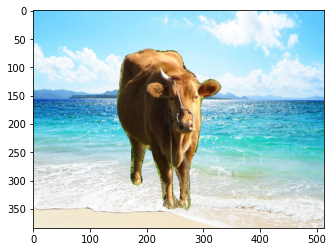

In [276]:
#소에 해당하는 곳은 cow_orig의 픽셀로, 그 외의 영역은 img_bg_blur의 픽셀로 채워준다
resized_cow = cv2.resize(cow_orig, (513,384)) #resize
cromakey_concat = np.where(cow_mask_color==255, resized_cow, resized_sea) 
plt.imshow(cv2.cvtColor(cromakey_concat, cv2.COLOR_BGR2RGB))
plt.show()

이제 시원해보이네요^^